# Setup and imports

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from pathlib import Path
from tqdm import tqdm
import napari
from csbdeep.utils import normalize
from utils import read_czi_image, read_czi_for_napari

# Load train and test images

In [17]:
# Define the directories containing your training/validation images and annotated ground truth pairs
train_img_directory = Path("./train_validation_data/train_data")
test_img_directory = Path("./test_data")

# Create a list containing all file paths .czi input images (train and test)
f_images = sorted(train_img_directory.glob("*.czi")) + sorted(test_img_directory.glob("*.czi"))

In [18]:
f_images

[WindowsPath('train_validation_data/train_data/1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1851I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1743I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1800I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1838I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1850I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1852I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1853I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi')]

In [19]:
# Initialize an empty list to hold the normalized images
normalized_images = []

# Iterate over each .czi stack contained in f_images
for filepath in tqdm(f_images):
    # Extract the filename
    filename = filepath.stem

    # Read the image from file and reshape it into channels-last format
    image = read_czi_image(filepath, channels=(0,1,2,3))

    # Normalize the read image along axes 0 and 1 (X and Y)
    normalized_image = normalize(image, axis=(0,1))

    # Append the normalize image along with its origin filename as a tuple into the list
    normalized_images.append((normalized_image, filename))

# Convert the list into a tuple (this is intended to be an immutable fixed set of images)
imgs = tuple(normalized_images)

100%|██████████| 12/12 [00:51<00:00,  4.31s/it]


# Load the model

In [20]:
import model as M

In [21]:
# Define the model_name you want to use from the models folder
model_name = 'model_gfp_dapi_bcat_lsd1_epoch_100'
# Load the different models here by changing the model name
model = M.UNet(None, model_name, basedir='models')

Loading network weights from 'weights_best.h5'.


In [22]:
model

UNet(model_gfp_dapi_bcat_lsd1_epoch_100): XYC → XYC
├─ Directory: C:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs\models\model_gfp_dapi_bcat_lsd1_epoch_100
└─ UNetConfig(n_dim=2, axes='XYC', n_channel_in=4, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=[None, None, 4], train_loss='categorical_crossentropy', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=4, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_class_weight=[1, 1, 1], unet_batch_norm=False, unet_dropout=0.0, patch_size=[512, 512])

# Apply model to obtain predictions, assign classes and store them as uint8 .tiff files

In [23]:
# Create the necessary folder structure if it does not exist in order to save the predictions after class assignment
prediction_tiff_directory = f"prediction_tiffs/{model_name}"

try:
    os.makedirs(prediction_tiff_directory)
    print(f"Output folder created: {prediction_tiff_directory}")
except FileExistsError:
    print(f"Output folder already exists: {prediction_tiff_directory}")

# Iterate over the (normalized_img, filename) tuple 
for (img, filename) in imgs:
    # Apply the model to obtain class probabilities
    prediction = model.predict(img, axes='XYC', n_tiles=(8,8,1))
    # Take the argmax along the channel axis to get the class with the highest probability
    class_assignment = np.argmax(prediction, axis=2)
    # Save the assigned classes as a tiff file
    tifffile.imwrite(f"{prediction_tiff_directory}/{filename}.tiff", class_assignment)

Output folder created: prediction_tiffs/model_gfp_dapi_bcat_lsd1_epoch_100


c:\Users\adiez_cmic\miniforge3\envs\EMBL_tensorflow\lib\site-packages\csbdeep\models\base_model.py:311: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +
100%|██████████| 64/64 [00:03<00:00, 19.30it/s]


# Display the predictions

In [24]:
# Remove images variable to free up memory
del imgs

# Add the filepaths to the predicted class .tiffs to a list
f_classes = sorted(Path(prediction_tiff_directory).glob("*.tiff"))

<h3>Display a single input image and class prediction in Napari (using sample_id)</h3>

In [43]:
# Define colormaps for channels (change as needed)
channel_colormaps = ['green', 'magenta',  'cyan', 'yellow']

# Display a single prediction of your choice using Napari
sample_id = "1799I"

# Checking for sample_id in both f_images and f_classes
for filepath in f_images:
    if sample_id in str(filepath):
        input_image_filepath = filepath

for filepath in f_classes:
    if sample_id in str(filepath):
        class_pred_filepath = filepath

# Show that particular input image and prediction pair in Napari for in-detail exploration
viewer = napari.Viewer(ndisplay=2)

input_image = read_czi_for_napari(input_image_filepath)
predicted_classes = tifffile.imread(class_pred_filepath)
filename_czi = input_image_filepath.stem
filename_tiff = class_pred_filepath.stem

for channel_index in range(input_image.shape[0]):
    viewer.add_image(
        input_image[channel_index],
        name=f"{filename_czi}_input_img_channel_{channel_index}",
        colormap=channel_colormaps[channel_index % len(channel_colormaps)],
        blending='additive'
    )

viewer.add_labels(predicted_classes, name=f"{filename_tiff}_labels", opacity=0.15)

<Labels layer '1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_labels' at 0x1f4ca935fa0>

<h3>Display all input image and class prediction pairs in Napari</h3>

In [32]:
# Extract sample_ids and create a mapping from sample_id to class prediction and image file paths
sample_id_to_files = {}

for filepath in f_classes:
    filename = filepath.name
    sample_id = filename.split("_")[0]
    if sample_id not in sample_id_to_files:
        sample_id_to_files[sample_id] = {'class': None, 'image': None}
    sample_id_to_files[sample_id]['class'] = filepath

for filepath in f_images:
    filename = filepath.name
    sample_id = filename.split("_")[0]
    if sample_id not in sample_id_to_files:
        sample_id_to_files[sample_id] = {'class': None, 'image': None}
    sample_id_to_files[sample_id]['image'] = filepath

sample_ids = list(sample_id_to_files.keys())
print(f"The following sample_ids will be displayed: {sample_ids}")

The following sample_ids will be displayed: ['1742I', '1743I', '1799I', '1800I', '1801I', '1837I', '1838I', '1849I', '1850I', '1851I', '1852I', '1853I']


In [42]:
# Create a new viewer instance to add all the images
viewer = napari.Viewer(ndisplay=2)

# Define colormaps for channels (change as needed)
channel_colormaps = ['green', 'magenta',  'cyan', 'yellow']

for sample_id, filepaths in sample_id_to_files.items():
    input_image_filepath = filepaths['image']
    class_pred_filepath = filepaths['class']

    if input_image_filepath and class_pred_filepath:
        input_image = read_czi_for_napari(input_image_filepath)
        predicted_classes = tifffile.imread(class_pred_filepath)
        filename_czi = input_image_filepath.stem
        filename_tiff = class_pred_filepath.stem

        for channel_index in range(input_image.shape[0]):  
            viewer.add_image(
                input_image[channel_index],
                name=f"{filename_czi}_input_img_channel_{channel_index}",
                colormap=channel_colormaps[channel_index % len(channel_colormaps)],
                blending='additive'
            )
        viewer.add_labels(predicted_classes, name=f"{filename_tiff}_labels", opacity=0.15)


# Save image and class prediction pairs side by side as PNGs

Output folder already exists: prediction_tiffs/model_gfp_dapi_bcat_lsd1_epoch_100


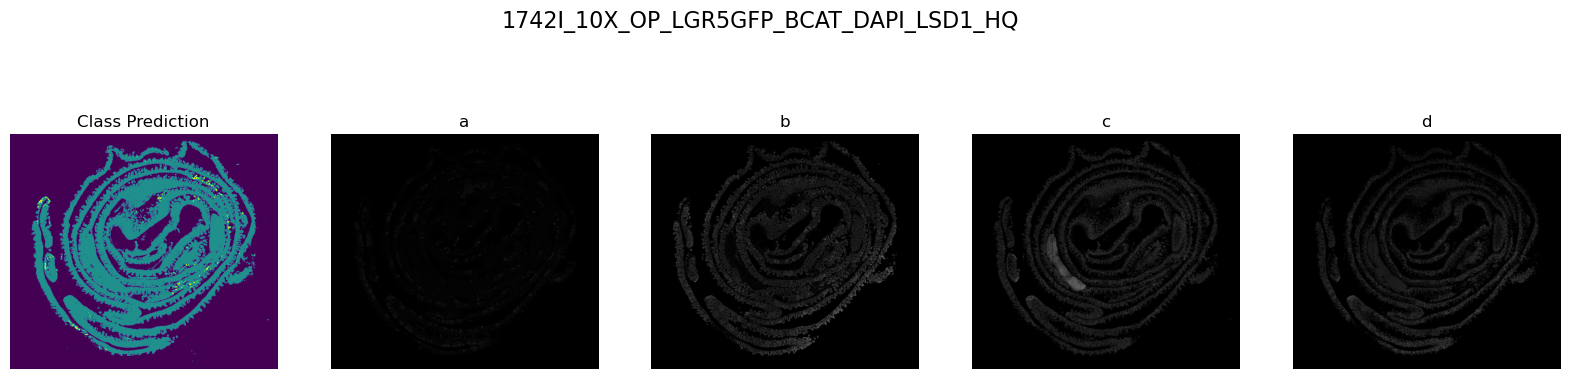

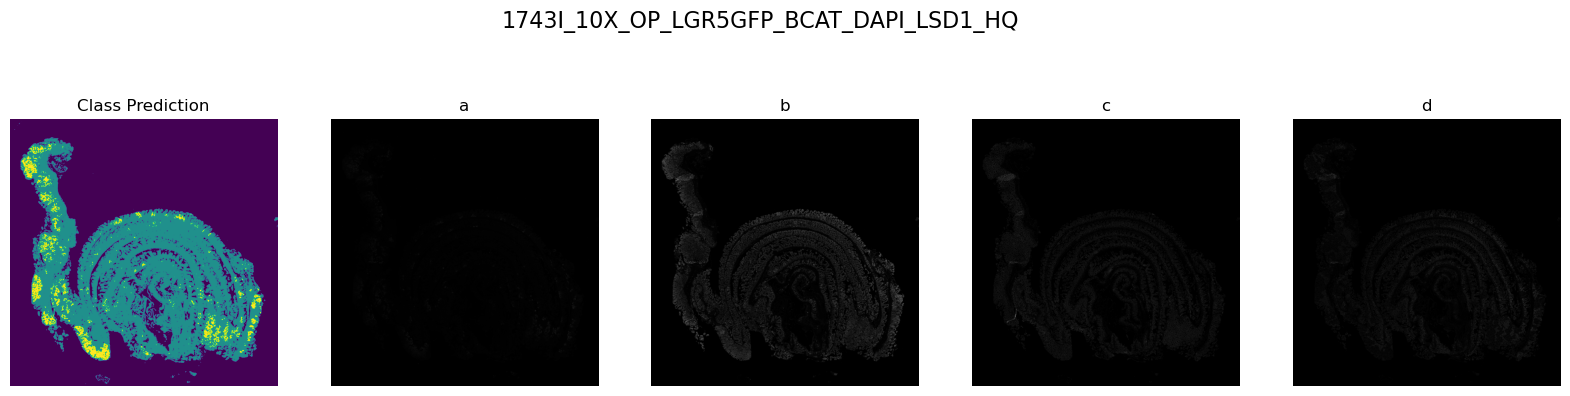

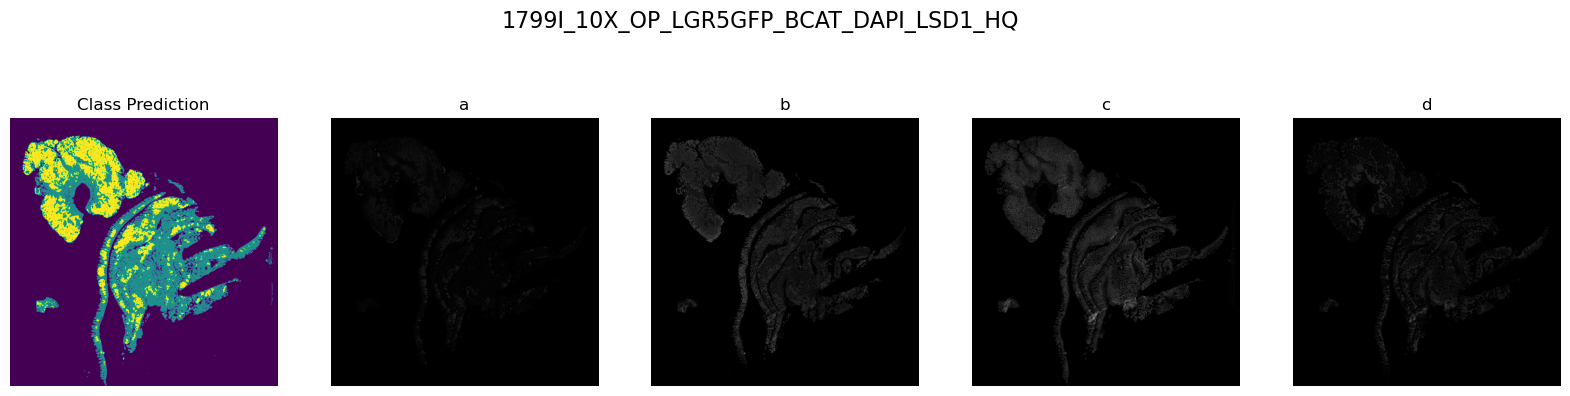

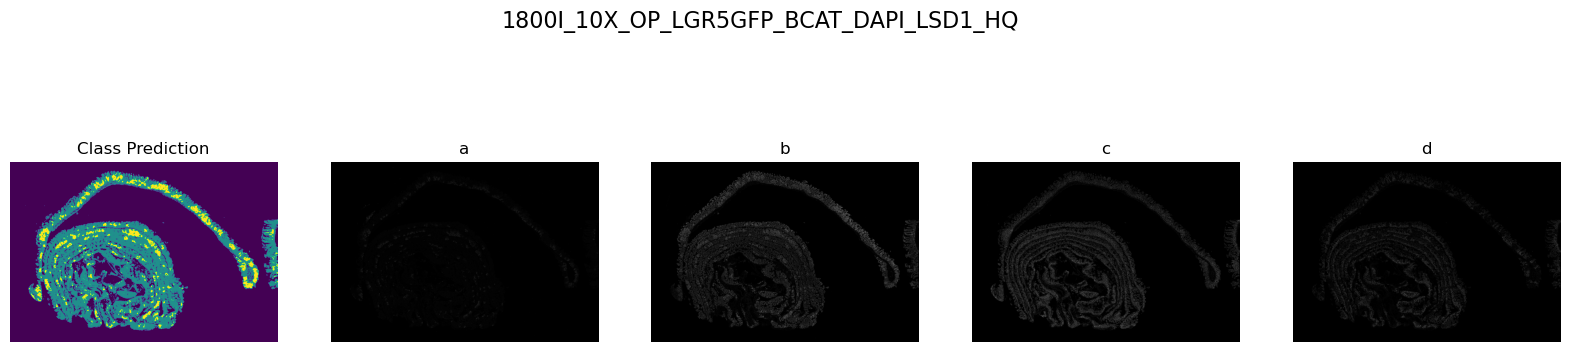

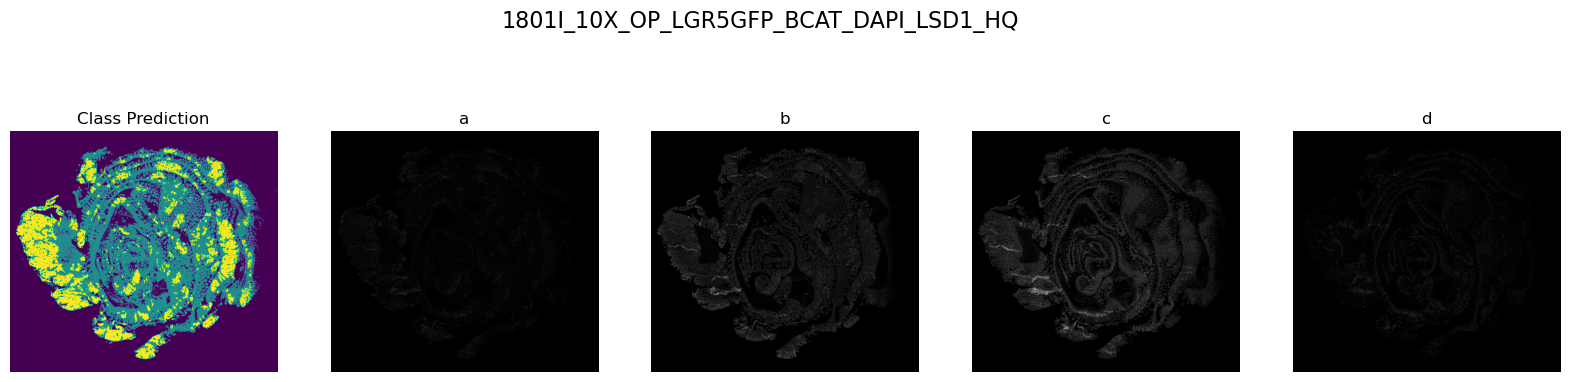

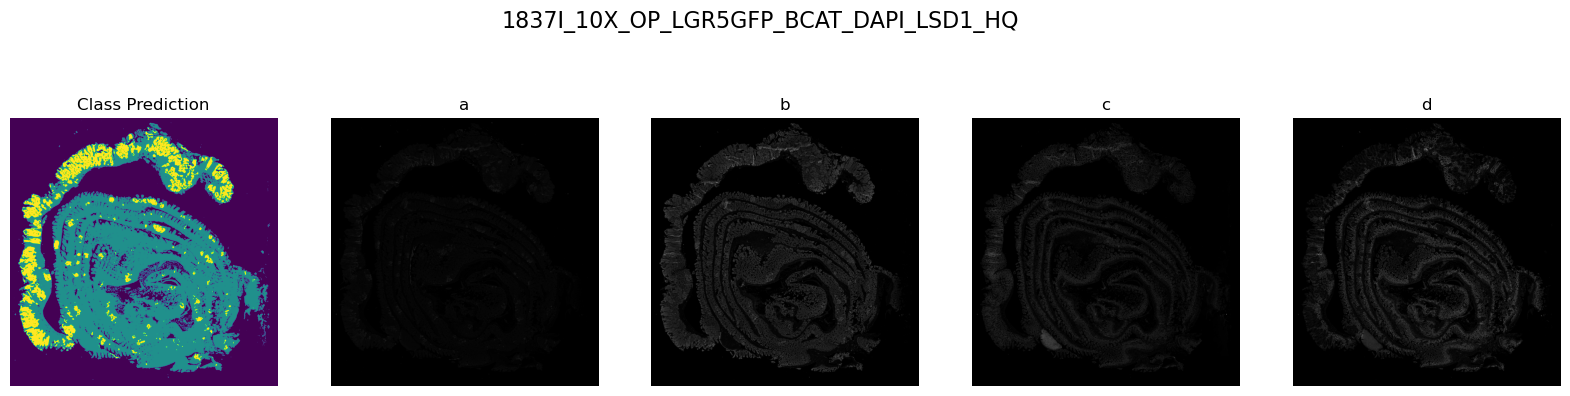

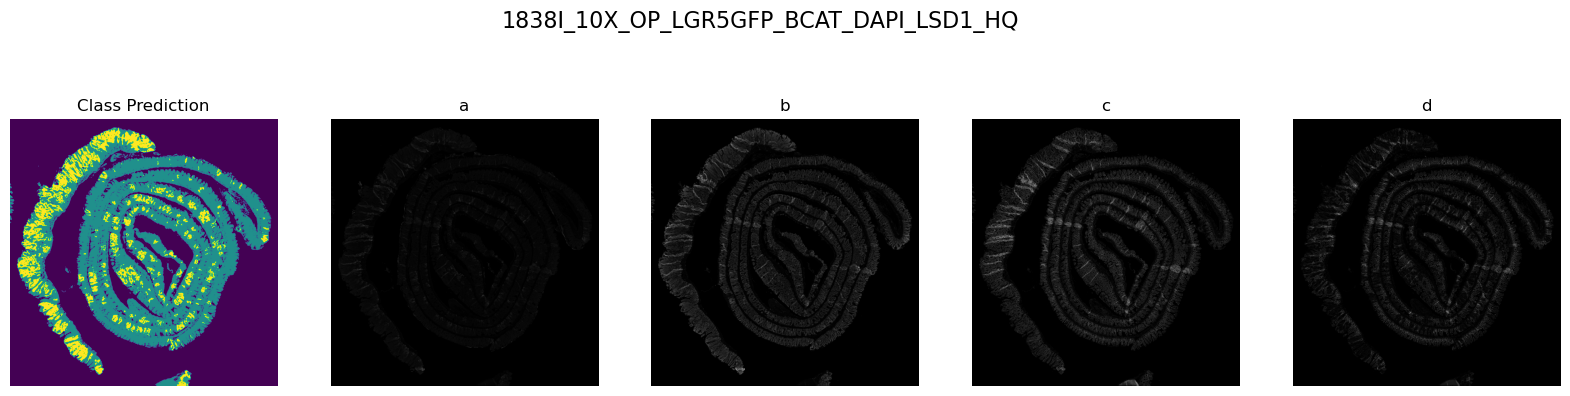

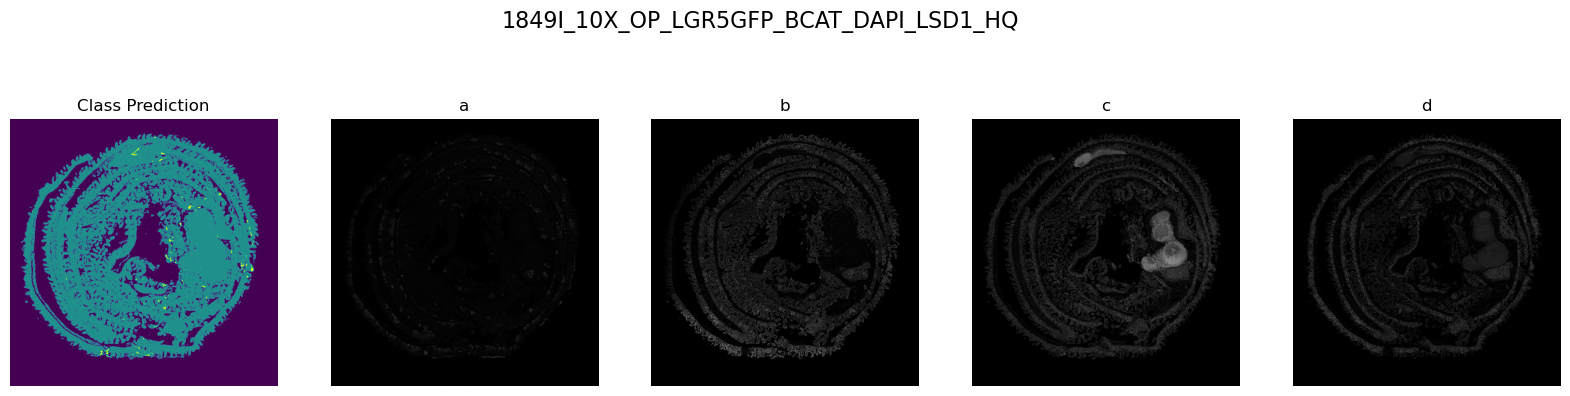

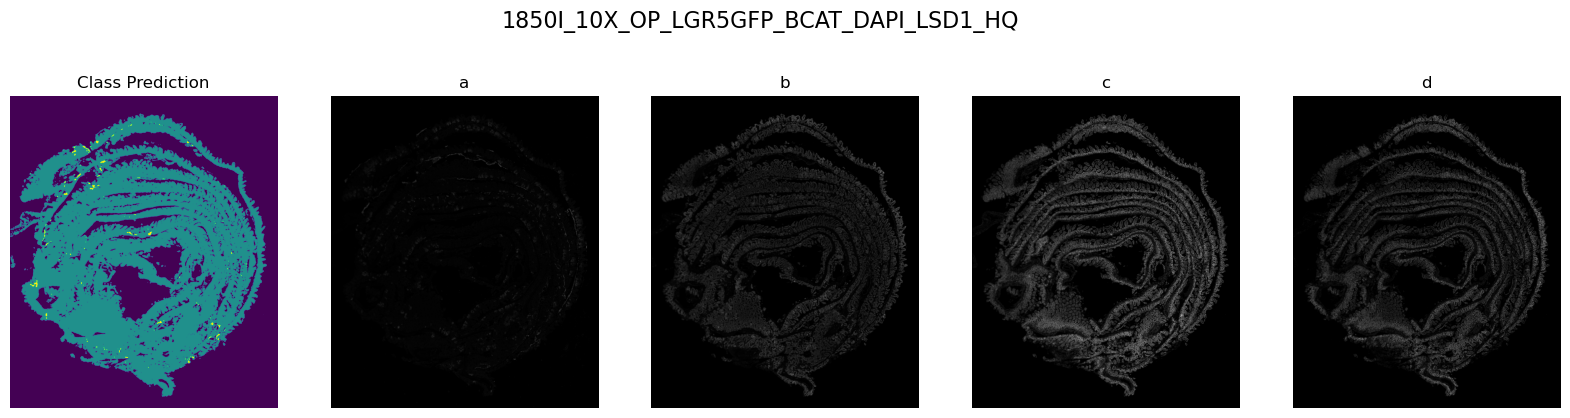

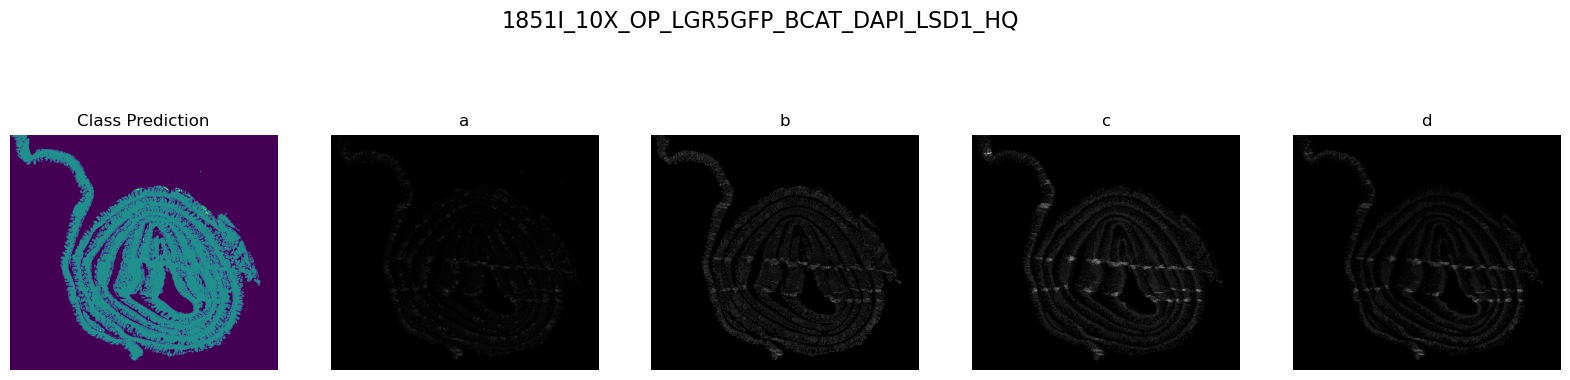

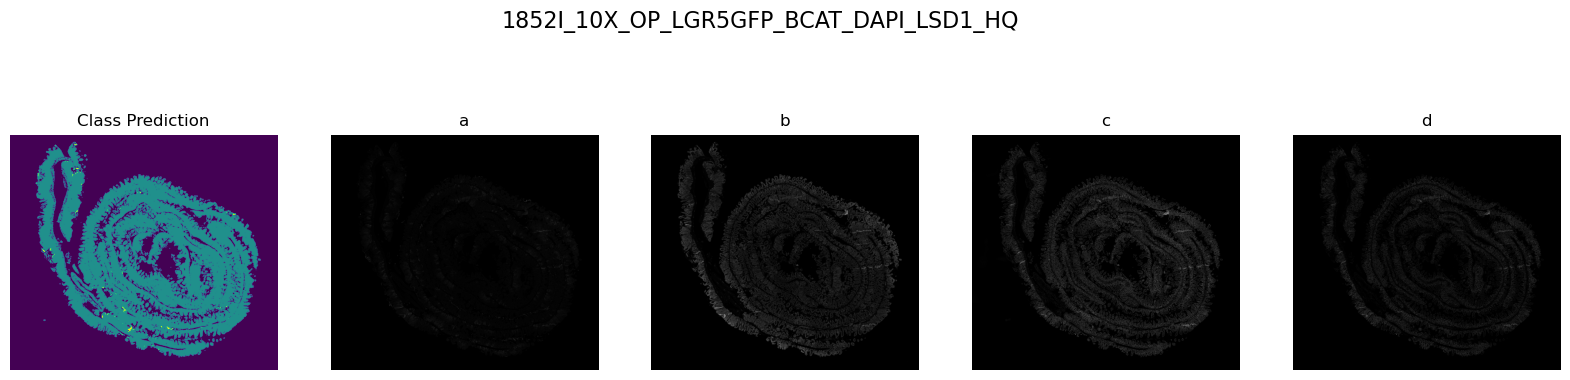

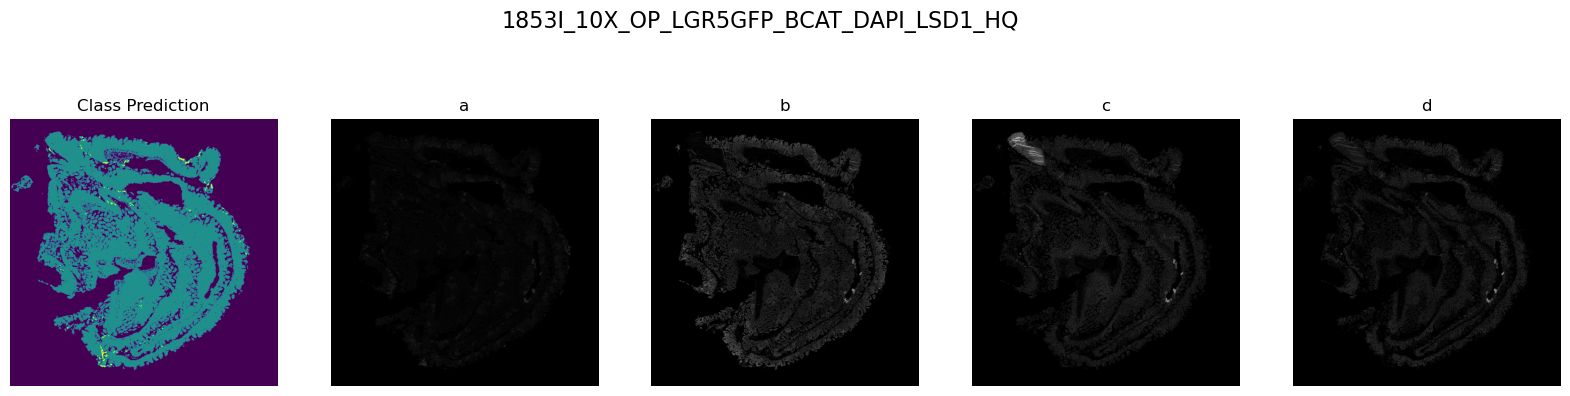

In [45]:
# Create the necessary folder structure if it does not exist
prediction_png_directory = f"prediction_tiffs/{model_name}"

try:
    os.makedirs(prediction_png_directory)
    print(f"Output folder created: {prediction_png_directory}")
except FileExistsError:
    print(f"Output folder already exists: {prediction_png_directory}")

# Loop through all the pairs, display and store them
for sample_id, filepaths in sample_id_to_files.items():
    input_image_filepath = filepaths['image']
    class_pred_filepath = filepaths['class']

    if input_image_filepath and class_pred_filepath:
        input_image = read_czi_for_napari(input_image_filepath)[:, ::4, ::4] # Use array slicing to show one of every 4 pixels
        predicted_classes = tifffile.imread(class_pred_filepath)[::4, ::4] # Use array slicing to show one of every 4 pixels
        filename_czi = input_image_filepath.stem

        # Plot the images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        
        # Display predicted_classes with viridis colormap
        axes[0].imshow(predicted_classes, cmap='viridis')
        axes[0].set_title('Class Prediction')
        axes[0].axis('off')

        # Display each channel in grayscale
        channel_titles = ['Lgr5-GFP', 'B-catenin', 'DAPI', 'LSD1']
        for i in range(4):
            axes[i+1].imshow(input_image[i], cmap='gray')
            axes[i+1].set_title(channel_titles[i])
            axes[i+1].axis('off')
        
        # Set the main title
        fig.suptitle(filename_czi, fontsize=16)

